# Muffin VS Chihuahua Classification using InceptionNet (InceptionV3)


*   Kirk Henrich Gamo & Ethan Jed Carbonell

## NOTE: Open this project in **Google Colab** to test
> https://colab.research.google.com/drive/1VmpF9TPfpcG7MbYHb0Qvk054kSBDsB9q?usp=sharing

# Setup & Data Loading

> We prepared the Google Colab environment by installing necessary libraries like kagglehub and torch. We then located the "Muffin vs. Chihuahua" dataset. We concluded by performing a brief exploration to confirm the dataset's structure, check the distribution of images per class, and visualize a few samples to ensure everything was loaded correctly.





In [ ]:
!pip install -q kagglehub torch torchvision matplotlib seaborn

import os
import torch
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import datasets
from pathlib import Path

#Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
mounted_path = Path("/kaggle/input/muffin-vs-chihuahua-image-classification")
download_path = Path("muffin-vs-chihuahua-image-classification")
DATA_PATH = None

if mounted_path.exists():
    print(f"Dataset found at the pre-mounted path: {mounted_path}")
    DATA_PATH = mounted_path
else:
    try:
        kagglehub.dataset_download(
            "samuelcortinhas/muffin-vs-chihuahua-image-classification",
            path=download_path
        )
        DATA_PATH = download_path
    except Exception as e:
        print(f"An error occurred during download: {e}")

if DATA_PATH:
    print("\nInspecting directory structure:")
    !ls -R {str(DATA_PATH)}
else:
    print("\nCould not locate or download the dataset.")

Dataset found at the pre-mounted path: /kaggle/input/muffin-vs-chihuahua-image-classification

Inspecting directory structure:
/kaggle/input/muffin-vs-chihuahua-image-classification:
test  train

/kaggle/input/muffin-vs-chihuahua-image-classification/test:
chihuahua  muffin

/kaggle/input/muffin-vs-chihuahua-image-classification/test/chihuahua:
img_0_1071.jpg	img_0_90.jpg	img_1_668.jpg	img_2_712.jpg	img_3_80.jpg
img_0_1074.jpg	img_0_930.jpg	img_1_682.jpg	img_2_722.jpg	img_3_819.jpg
img_0_1082.jpg	img_0_935.jpg	img_1_685.jpg	img_2_731.jpg	img_3_824.jpg
img_0_1087.jpg	img_0_939.jpg	img_1_68.jpg	img_2_733.jpg	img_3_836.jpg
img_0_1107.jpg	img_0_947.jpg	img_1_691.jpg	img_2_734.jpg	img_3_839.jpg
img_0_1110.jpg	img_0_94.jpg	img_1_708.jpg	img_2_735.jpg	img_3_843.jpg
img_0_1112.jpg	img_0_951.jpg	img_1_712.jpg	img_2_747.jpg	img_3_854.jpg
img_0_1117.jpg	img_0_960.jpg	img_1_722.jpg	img_2_752.jpg	img_3_856.jpg
img_0_1122.jpg	img_0_964.jpg	img_1_731.jpg	img_2_763.jpg	img_3_886.jpg
img_0_1133.jpg	img

Image distribution:
Training set: {'muffin': 2174, 'chihuahua': 2559}
Testing set:  {'muffin': 544, 'chihuahua': 640}

Visualizing sample images from the training set:


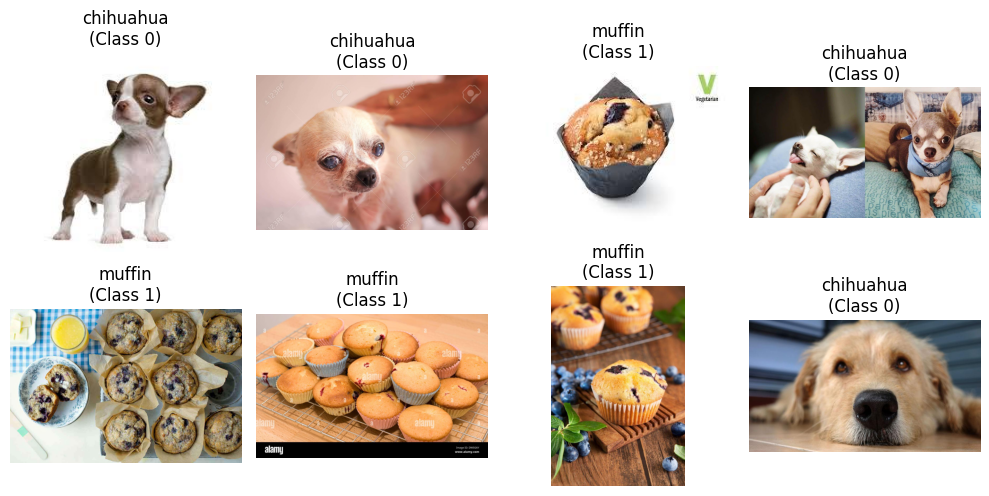

In [ ]:
# Define paths to train and test directories
train_dir = DATA_PATH / "train"
test_dir = DATA_PATH / "test"

# Count images in each directory
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

print("Image distribution:")
print(f"Training set: {count_images(train_dir)}")
print(f"Testing set:  {count_images(test_dir)}")

# Visualize some sample images
print("\nVisualizing sample images from the training set:")

# Use torchvision's ImageFolder to easily load data
temp_dataset = datasets.ImageFolder(train_dir)
class_names = temp_dataset.classes

plt.figure(figsize=(10, 5))
for i in range(8):
    # Get a random image
    idx = np.random.randint(0, len(temp_dataset))
    image, label_idx = temp_dataset[idx]
    label_name = class_names[label_idx]

    # Plot
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f"{label_name}\n(Class {label_idx})")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Data Preprocessing

> Prepared the images for the model.
<br> We defined distinct transformation pipelines for our data:
<br>one for training that included data augmentation (random cropping and flipping) to help the model generalize, and another for validation and testing with standard resizing and normalization.
<br>We then split our original training data into a training set and a validation set (85/15 split) and wrapped all three datasets (train, validation, test) in PyTorch DataLoaders to efficiently feed them to the model in batches.



In [ ]:
from torchvision import transforms

# InceptionV3 expects input images of size 299x299
IMG_SIZE = 299

# Define the normalization transform using ImageNet stats
# Standard values for models pretrained on ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Transform pipeline for the training data with augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Transform pipeline for validation and testing data (no augmentation)
# Resize and CenterCrop to get a consistent 299x299 view
val_test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 1),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

print("Image transformations defined successfully.")
print(f"Input image size set to: {IMG_SIZE}x{IMG_SIZE}")

Image transformations defined successfully.
Input image size set to: 299x299


In [ ]:
from torch.utils.data import DataLoader, random_split

train_dir = DATA_PATH / "train"
test_dir = DATA_PATH / "test"

# Load the full training dataset (without transforms)
full_train_dataset_no_transform = datasets.ImageFolder(train_dir)
class_names = full_train_dataset_no_transform.classes
print(f"Class names: {class_names}")
print(f"Class to index mapping: {full_train_dataset_no_transform.class_to_idx}")


# Split size (85% training, 15% validation)
val_split = 0.15
val_size = int(val_split * len(full_train_dataset_no_transform))
train_size = len(full_train_dataset_no_transform) - val_size

generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(
    full_train_dataset_no_transform,
    [train_size, val_size],
    generator=generator
)

train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_test_transform

# Test dataset with the transform
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)


print(f"\nFull training data count: {len(full_train_dataset_no_transform)}")
print(f"Splitting into:")
print(f" -> Training subset:   {len(train_subset)} samples")
print(f" -> Validation subset: {len(val_subset)} samples")
print(f"Test data count:         {len(test_dataset)} samples")

Class names: ['chihuahua', 'muffin']
Class to index mapping: {'chihuahua': 0, 'muffin': 1}

Full training data count: 4733
Splitting into:
 -> Training subset:   4024 samples
 -> Validation subset: 709 samples
Test data count:         1184 samples


DataLoaders created with batch size: 32

Visualizing one batch of training data...


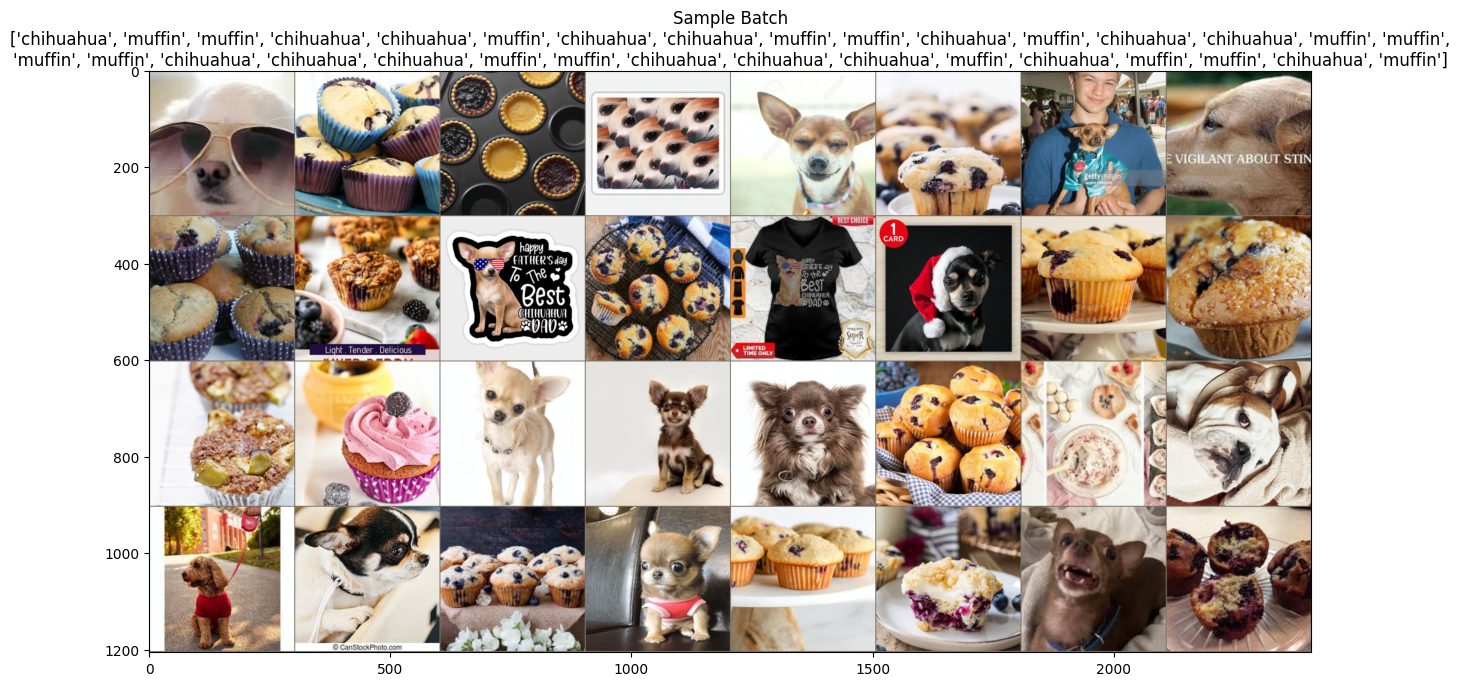

In [ ]:
import torchvision

BATCH_SIZE = 32

# Create DataLoaders
train_dataloader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count()
)

val_dataloader = DataLoader(
    dataset=val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count()
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count()
)

print(f"DataLoaders created with batch size: {BATCH_SIZE}")

# Visualizing batch
print("\nVisualizing one batch of training data...")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(imagenet_mean)
    std = np.array(imagenet_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, wrap=True)
    plt.pause(0.001)

inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs, nrow=8)

plt.figure(figsize=(15, 10))
class_titles = [class_names[x] for x in classes]
imshow(out, title=f"Sample Batch\n{class_titles}")

# Model Architecture

> We built our classifier using transfer learning.
<br>We loaded a pre-trained InceptionV3 model with weights learned from ImageNet.
<br>We "froze" all the existing layers to use them as a fixed feature extractor.
<br>We then replaced the model's final classification layer with a new one designed for our binary task (2 outputs).
<br><br>Then lastly, we defined our loss function (CrossEntropyLoss) and the Adam optimizer, instructing it to only train the parameters of our new, unfrozen classification layer.



In [ ]:
from torchvision import models

# Pretrained InceptionV3 model
# Using the latest recommended weights
weights = models.Inception_V3_Weights.IMAGENET1K_V1
model = models.inception_v3(weights=weights)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 203MB/s] 


In [ ]:
# Freeze all the parameters in the pre-trained model
for param in model.parameters():
    param.requires_grad = False

print("All pre-trained layers have been frozen.")

All pre-trained layers have been frozen.


In [ ]:
import torch.nn as nn

num_ftrs = model.fc.in_features
print(f"Number of input features for the final layer: {num_ftrs}")

model.fc = nn.Linear(num_ftrs, len(class_names))

print("\nModel's final layer before modification:")
print("... (original model.fc): Linear(in_features=2048, out_features=1000, bias=True)")

print("\nModel's final layer after modification:")
print(model.fc)

if hasattr(model, 'AuxLogits') and model.AuxLogits is not None:
    num_ftrs_aux = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs_aux, len(class_names))
    print("\nAuxiliary classifier layer also modified.")

Number of input features for the final layer: 2048

Model's final layer before modification:
... (original model.fc): Linear(in_features=2048, out_features=1000, bias=True)

Model's final layer after modification:
Linear(in_features=2048, out_features=2, bias=True)

Auxiliary classifier layer also modified.


In [ ]:
import torch.optim as optim

model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# We pass only the parameters that should be updated to the optimizer.
# These are the parameters of the new `fc` layers we created. (can be seen on the printed model architecture at the very end of this notebook)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        print(f" -> Will train parameter: {name}")

optimizer = optim.Adam(params_to_update, lr=0.001)

print(f"\nModel moved to device: {device}")
print(f"Loss function: {criterion}")
print(f"Optimizer: Adam with learning rate 0.001")

 -> Will train parameter: AuxLogits.fc.weight
 -> Will train parameter: AuxLogits.fc.bias
 -> Will train parameter: fc.weight
 -> Will train parameter: fc.bias

Model moved to device: cuda
Loss function: CrossEntropyLoss()
Optimizer: Adam with learning rate 0.001


# Phase 4: Training Setup (Feature Extraction)


> Initial model training. We created a training loop function that handled both training and validation steps, calculated accuracy and loss, and updated the model's weights. This function implemented checkpointing to save the model with the best validation accuracy and early stopping to halt training if performance stopped improving.



In [ ]:
import time
import copy

def train_model(model, criterion, optimizer, train_dataloader, val_dataloader,
                num_epochs=10, patience=3, model_save_path='best_model.pth'):

    start_time = time.time()

    # Variables for tracking best performance and early stopping
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train' and isinstance(model, models.Inception3):
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2 # As recommended in the InceptionV3 paper
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            # Store history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_save_path)
                epochs_no_improve = 0
            elif phase == 'val':
                epochs_no_improve += 1

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after {patience} epochs with no improvement.')
            break

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

print("Training function `train_model` is defined.")

Training function `train_model` is defined.


In [ ]:
NUM_EPOCHS = 15
PATIENCE = 3
MODEL_SAVE_PATH = "inception_v3_muffin_chihuahua_best.pth"

model, history = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    model_save_path=MODEL_SAVE_PATH
)

Epoch 1/15
----------
Train Loss: 0.2317 Acc: 0.9386
Val Loss: 0.0707 Acc: 0.9929
✨ Validation accuracy improved! Saving model to inception_v3_muffin_chihuahua_best.pth

Epoch 2/15
----------
Train Loss: 0.1057 Acc: 0.9729
Val Loss: 0.0499 Acc: 0.9901

Epoch 3/15
----------
Train Loss: 0.0852 Acc: 0.9784
Val Loss: 0.0447 Acc: 0.9915

Epoch 4/15
----------
Train Loss: 0.0952 Acc: 0.9727
Val Loss: 0.0381 Acc: 0.9901

Early stopping triggered after 3 epochs with no improvement.
Training complete in 4m 8s
Best val Acc: 0.9929


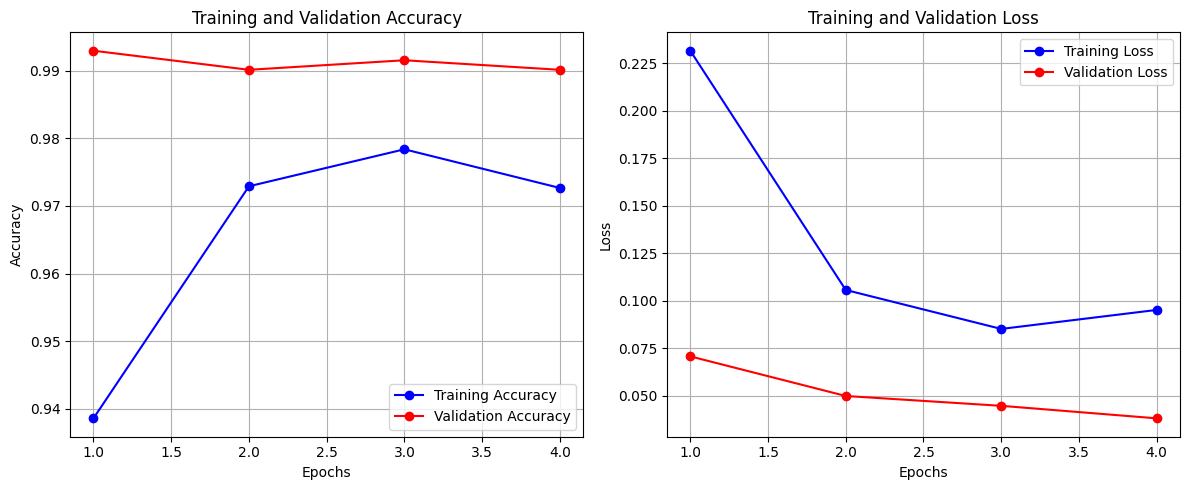

In [ ]:
# Plot the training and validation accuracy and loss
train_acc = [h for h in history['train_acc']]
val_acc = [h for h in history['val_acc']]
train_loss = history['train_loss']
val_loss = history['val_loss']

epochs_ran = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_ran, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs_ran, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs_ran, val_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Phase 5: Fine-tuning

> To potentially improve performance further, we performed fine-tuning. We took our best model from the previous phase and unfroze all of its layers, making the entire network trainable. We then created a new optimizer with a very low learning rate to make subtle adjustments to the powerful pre-trained weights without destroying them. Running the training loop again with this setup allowed the deeper layers to adapt slightly to our specific dataset (this pushed the model's validation accuracy to a perfect 100%.)



In [ ]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Unfreeze all model parameters
for param in model.parameters():
    param.requires_grad = True

print("All model layers have been unfrozen and are now trainable.")

All model layers have been unfrozen and are now trainable.


In [ ]:
# lower learning rate for fine-tuning
fine_tune_optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("New optimizer created for fine-tuning with a lower learning rate (lr=0.0001).")
print("All model parameters are now included in the optimizer.")

New optimizer created for fine-tuning with a lower learning rate (lr=0.0001).
All model parameters are now included in the optimizer.


In [ ]:
# New save path for the fine-tuned model
FINETUNED_MODEL_SAVE_PATH = "inception_v3_finetuned_best.pth"

# Training again for 10 epoch with early stopping
print("\nStarting fine-tuning...")
model_finetuned, history_finetuned = train_model(
    model=model,
    criterion=criterion,
    optimizer=fine_tune_optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=3,
    model_save_path=FINETUNED_MODEL_SAVE_PATH
)


Starting fine-tuning...
Epoch 1/10
----------
Train Loss: 0.0584 Acc: 0.9863
Val Loss: 0.0028 Acc: 1.0000
✨ Validation accuracy improved! Saving model to inception_v3_finetuned_best.pth

Epoch 2/10
----------
Train Loss: 0.0141 Acc: 0.9968
Val Loss: 0.0015 Acc: 1.0000

Epoch 3/10
----------
Train Loss: 0.0018 Acc: 1.0000
Val Loss: 0.0002 Acc: 1.0000

Epoch 4/10
----------
Train Loss: 0.0038 Acc: 0.9993
Val Loss: 0.0016 Acc: 1.0000

Early stopping triggered after 3 epochs with no improvement.
Training complete in 4m 58s
Best val Acc: 1.0000


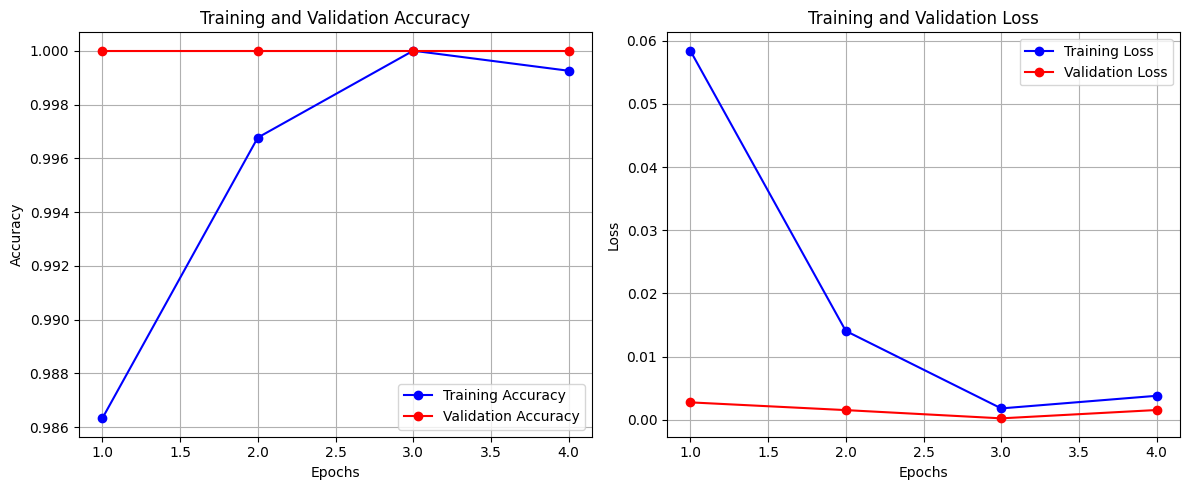

In [ ]:
# After fine-tuning
train_acc = [h for h in history_finetuned['train_acc']]
val_acc = [h for h in history_finetuned['val_acc']]
train_loss = history_finetuned['train_loss']
val_loss = history_finetuned['val_loss']

epochs_ran = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_ran, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs_ran, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs_ran, val_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation & Visualization

> We loaded our best fine-tuned model and generated predictions for all test images. We then calculated detailed metrics using a classification_report (precision, recall, F1-score) and visualized the results with a confusion_matrix to see the exact breakdown of correct versus incorrect predictions.



In [ ]:
from tqdm.auto import tqdm

# Load the best fine-tuned model
model_finetuned.load_state_dict(torch.load(FINETUNED_MODEL_SAVE_PATH))

model_finetuned.to(device)
model_finetuned.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []

print("Making predictions on the test set...")

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Test Batches"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_finetuned(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nPrediction complete.")

Making predictions on the test set...


Test Batches:   0%|          | 0/37 [00:00<?, ?it/s]


Prediction complete.


Classification Report:
              precision    recall  f1-score   support

   chihuahua       1.00      1.00      1.00       640
      muffin       1.00      1.00      1.00       544

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184



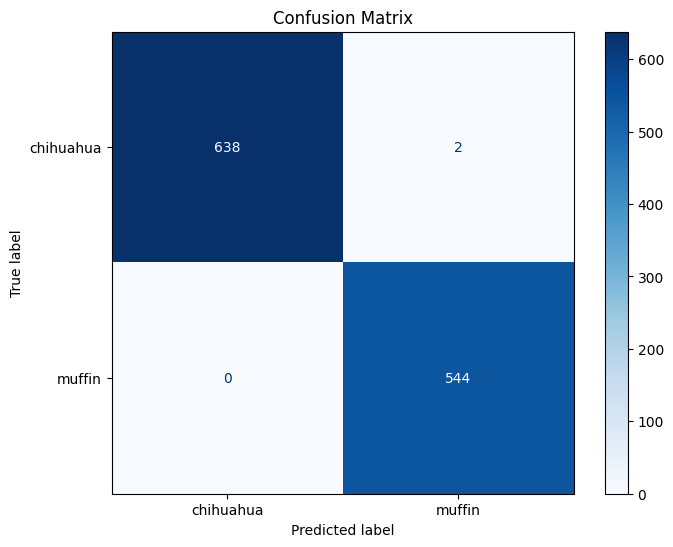

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Correctly classified as 'chihuahua' (True Negative) 638<br>
'chihuahua' misclassified as 'muffin' (False Positive) 2<br>
'muffin' misclassified as 'chihuahua' (False Negative) 0<br>
Correctly classified as 'muffin' (True Positive) 544

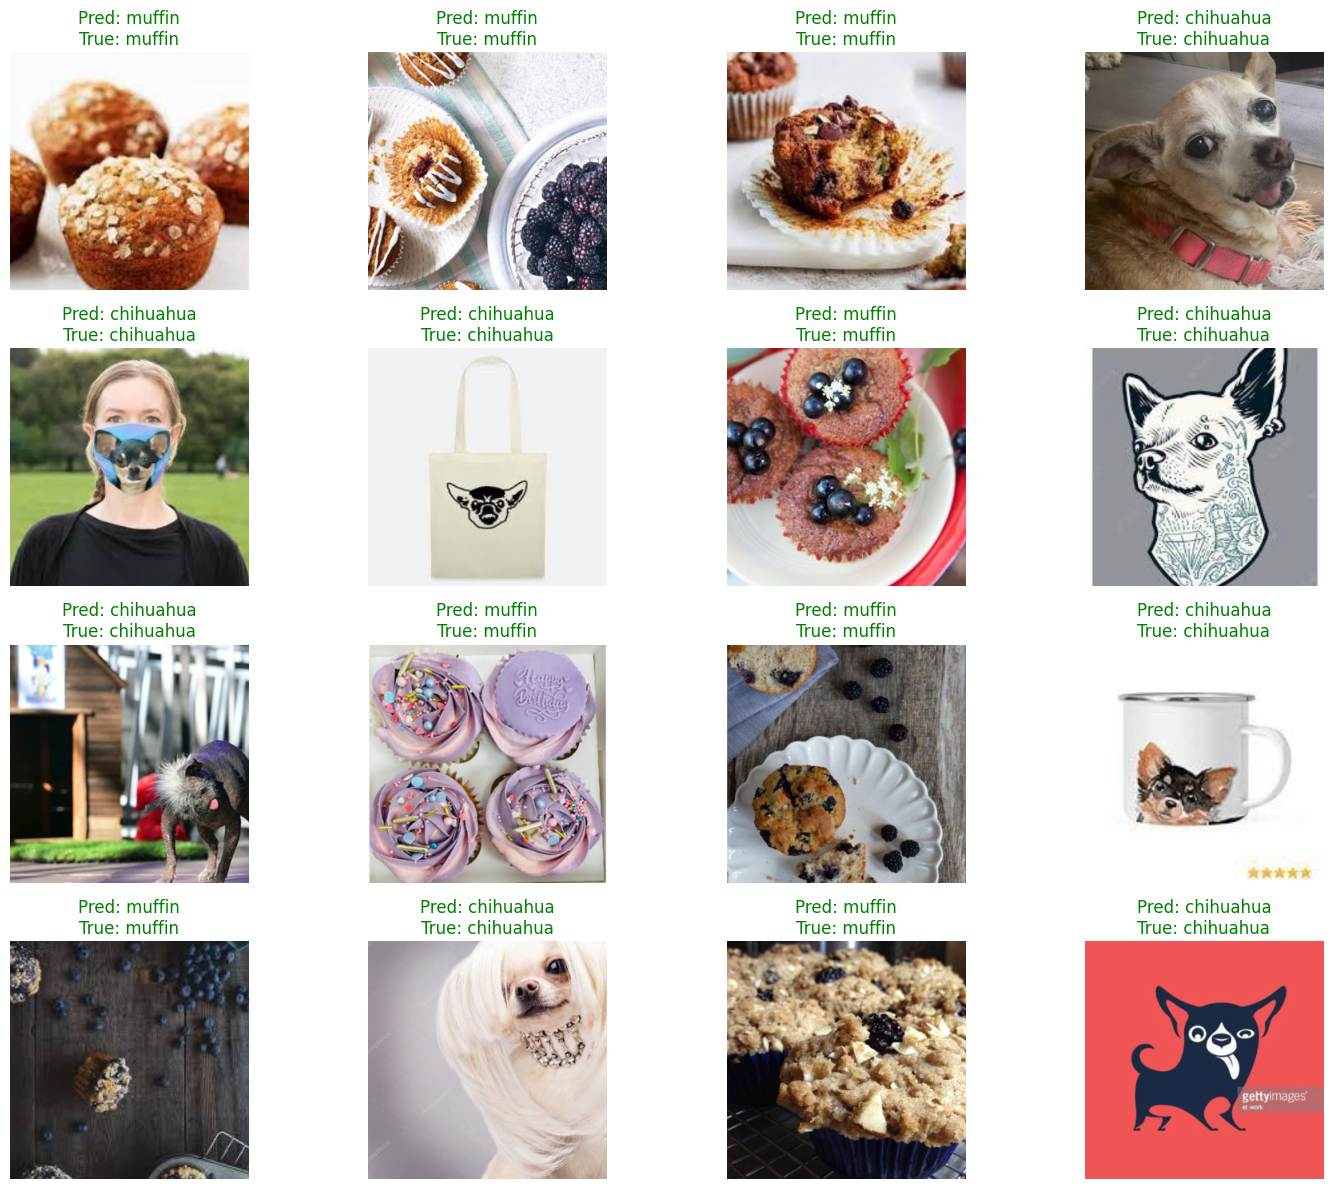

In [ ]:
import random

class_to_idx = test_dataset.class_to_idx
chihuahua_idx = class_to_idx['chihuahua']
muffin_idx = class_to_idx['muffin']

# Get the indices of all images for each class in the test set
targets = np.array(test_dataset.targets)
chihuahua_indices = np.where(targets == chihuahua_idx)[0]
muffin_indices = np.where(targets == muffin_idx)[0]

# Randomly sample 8 indices from each class
num_samples_per_class = 8
random_chihuahua_indices = random.sample(list(chihuahua_indices), num_samples_per_class)
random_muffin_indices = random.sample(list(muffin_indices), num_samples_per_class)

# Combine the indices and shuffle them for a mixed display
selected_indices = random_chihuahua_indices + random_muffin_indices
random.shuffle(selected_indices)

# Retrieve the images and labels for the selected indices
images_to_show = []
labels_to_show = []
for idx in selected_indices:
    # The dataset object automatically applies the transform when we access an item
    image, label = test_dataset[idx]
    images_to_show.append(image)
    labels_to_show.append(label)

# Stack the list of tensors into a single batch tensor
image_batch = torch.stack(images_to_show)
label_batch = torch.tensor(labels_to_show)

# --- Get model predictions for our custom batch ---
with torch.no_grad():
    model_finetuned.to(device)
    image_batch_device = image_batch.to(device)
    outputs = model_finetuned(image_batch_device)
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu()

# --- Plot the images with their predicted and true labels ---
plt.figure(figsize=(15, 12))
for i in range(len(selected_indices)): # Loop through our 16 selected images
    ax = plt.subplot(4, 4, i + 1)

    # Un-normalize and display the image
    img = image_batch[i].numpy().transpose((1, 2, 0))
    mean = np.array(imagenet_mean)
    std = np.array(imagenet_std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    pred_label = class_names[preds[i]]
    true_label = class_names[label_batch[i]]

    # Set title color to green for correct predictions, red for incorrect
    color = "green" if pred_label == true_label else "red"

    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [ ]:
print(model_finetuned)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri